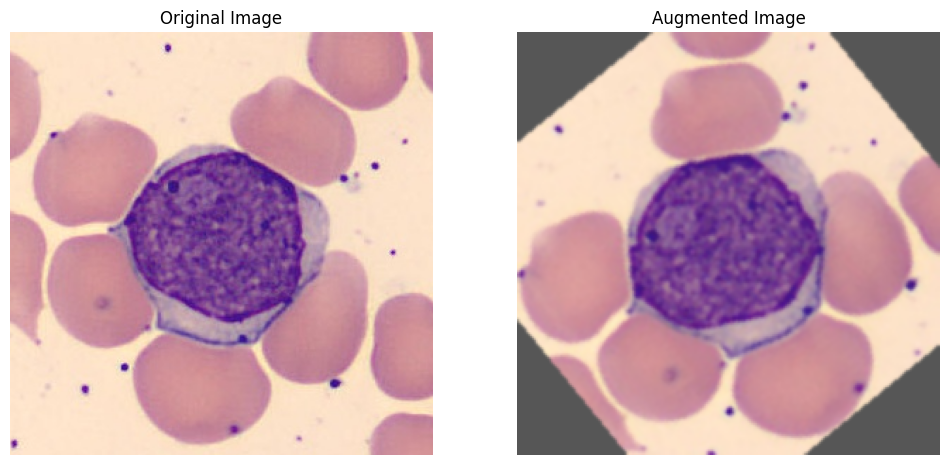

In [376]:

from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

class RandomRotationWithBorderReplication:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        angle = np.random.uniform(-self.degrees, self.degrees)
        img_array = np.array(img)
        h, w = img_array.shape[:2]
        center = (w / 2, h / 2)

        # Calculate the rotation matrix
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        # Perform the rotation
        rotated_img = cv2.warpAffine(img_array, rot_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

        # Convert back to PIL image
        return Image.fromarray(rotated_img)
    

class GaussianBlur(transforms.RandomApply):
    """
    Apply Gaussian Blur to the PIL image.
    """

    def __init__(self, *, p: float = 0.5, radius_min: float = 0.1, radius_max: float = 2.0):
        # NOTE: torchvision is applying 1 - probability to return the original image
        keep_p = 1 - p
        transform = transforms.GaussianBlur(kernel_size=9, sigma=(radius_min, radius_max))
        super().__init__(transforms=[transform], p=keep_p)

   

def visualize_augmentations(original_img,cropped_image, augmentation):
    # Apply the augmentation
    augmented_img = augmentation(cropped_image)

    # Plot original and augmented images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Augmented Image')
    plt.imshow(augmented_img)
    plt.axis('off')

    plt.show()

global_crops_size=224
global_crops_scale=[0.6,1]
augmentations = transforms.Compose([
#  transforms.RandomApply([HEDJitter(factor=0.07)], p=0.5),
    transforms.RandomResizedCrop(global_crops_size, scale=global_crops_scale, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.3, hue=0.15)
    ], p=0.8),
    #RandomRotationWithBorderReplication(360),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=(0, 360),fill=list(random.randint(0,255)*np.array([1, 1, 1])))
    ],p=0.5),
    #transforms.RandomGrayscale(p=0.2),
    GaussianBlur(p=0.1),
    #  transforms.RandomSolarize(threshold=128, p=0.2),
])

# Load an image
im_path='/mnt/ceph_vol/segmentation_WBC/Dataset 2/001.bmp'
original_img = Image.open(im_path).convert("RGB")  # Update this path
cropped_img=get_image_data(im_path)
# Visualize the augmentations
visualize_augmentations(original_img,cropped_img, augmentations)

In [307]:
list(random.randint(0,255)*np.array([1, 1, 1]))

[210, 210, 210]

In [258]:
def get_image_data( filepath,dimension=512) -> Image:
        # Load image from jpeg file

        patch = Image.open(filepath).convert(mode="RGB")

        # Resize the image so that the largest dimension equals the specified dimension
        w, h = patch.size
        if h > w:
            new_h = dimension
            new_w = int(new_h * w / h)
        else:
            new_w = dimension
            new_h = int(new_w * h / w)
        patch = patch.resize((new_w, new_h), Image.Resampling.LANCZOS)


            # Perform a random crop if needed
        if new_w > dimension or new_h > dimension:
            if new_w > dimension:
                left = random.randint(0, new_w - dimension)
            else:
                left = 0
            if new_h > dimension:
                top = random.randint(0, new_h - dimension)
            else:
                top = 0

            patch = patch.crop((left, top, left + dimension, top + dimension))

        return patch